In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import sys
import seaborn as sns
from scipy import signal
from scipy import optimize

import matplotlib
matplotlib.rcParams.update({'font.size': 22})

sys.path.append('/Users/kperks/mnt/engram/scripts/Python/Analysis/')
from ClassDef_AmplitudeShift_Stable import AmpShift_Stable

exptpath = Path.cwd().resolve().parents[0] #assumes running notebook from /data_processed
data_folder = exptpath / 'data_raw'
figure_folder = Path.cwd().resolve().parents[2] / 'engram_share' / 'locker' / 'GranularCellPaperResources' / 'Figure_RawEPScomponents'


In [2]:
def compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur):
    
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

    CmdTrig = expt.get_events('CmdTrig')

    #uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    # ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-5,20)

    dt = expt.get_dt('lowgain')
    Ramp_uc = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    #coupled
#     bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_c)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    # ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    
    cmd_df = expt.filter_marker_df_code(bout_df,['C'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    C_latency = np.median(cmd_df.time.values-cmd_t)

    cmd_df = expt.filter_marker_df_code(bout_df,['U'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    xtime,cmd_sweeps = expt.get_sweepsmat('lowgain',cmd_t+C_latency,sweepdur)
    cmd_R = np.mean(cmd_sweeps,1)-np.mean(cmd_sweeps,1)[0]

#     trialmat = np.asarray([sweep-cmd_R for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-5,20)
    plt.plot(xtime,cmd_R,color = 'black')

    dt = expt.get_dt('lowgain')
    Ramp_c = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    plt.figure(figsize = (4,5))
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
    plt.ylim(-5,20)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift']),Ramp_uc,Ramp_c

def uncoupled_ampshift(expt,bout_uc,sweepdur):
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

    CmdTrig = expt.get_events('CmdTrig')

    #uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

    trialmat = []
    for a in np.unique(trial_df['ampshift_round']):
        theseT = trial_df[trial_df['ampshift_round']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

    plt.figure(figsize=(8,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
#     plt.ylim(-10,50)

    dt = expt.get_dt('lowgain')
    Ramp_uc = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])
    
    return np.unique(trial_df['ampshift_round']),Ramp_uc

def coupled_ampshift(expt,bout_c,sweepdur):    
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    CmdTrig = expt.get_events('CmdTrig')
    
    bout_df = expt.filter_marker_df_time(marker_df,bout_c)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

    trialmat = []
    for a in np.unique(trial_df['ampshift_round']):
        theseT = trial_df[trial_df['ampshift_round']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    
    cmd_df = expt.filter_marker_df_code(bout_df,['C'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    C_latency = np.median(cmd_df.time.values-cmd_t)

    cmd_df = expt.filter_marker_df_code(bout_df,['U'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    xtime,cmd_sweeps = expt.get_sweepsmat('lowgain',cmd_t+C_latency,sweepdur)
    cmd_R = np.mean(cmd_sweeps,1)-np.mean(cmd_sweeps,1)[0]

    trialmat = np.asarray([sweep-cmd_R for sweep in trialmat.T]).T

    plt.figure(figsize=(8,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-10,50)

    dt = expt.get_dt('lowgain')
    Ramp_c = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    plt.figure(figsize = (5,5))
    plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
    plt.ylim(-5,50)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift_round']),Ramp_c

def calc_peaks(xtime,sweeps, order, min_peakt,threshold_h,dt):
    R = sweeps #np.mean(sweeps,1)-np.mean(sweeps,1)[0]
    
    nsamp=int(order/dt) #the window of comparison in nsamp for order; 2msec seemed good
    epsp_ = signal.argrelextrema(R,np.greater_equal,order = nsamp)[0]
    epsp_ = epsp_[np.where((epsp_*dt)>min_peakt)[0]]
    epsp = []
    measure = epsp_
    for i in measure:
        lb = int(min_peakt/dt)
        rb = len(R)-1
        min_height = np.min([abs(R[i]-R[lb]),abs(R[i]-R[rb])])
        if min_height>threshold_h:
            epsp.append(i)
    if len(epsp)>0:
        epsp = np.min(epsp)
    elif len(epsp)==0:
        epsp = np.NaN

    R_filt = R #signal.medfilt(R,[11])
    y = signal.medfilt(np.concatenate([[0],np.diff(R_filt)]),[25]) #-threshold_dvdt
    accel = signal.medfilt(np.concatenate([[0],np.diff(y)]),[11])   

    dvdt_start = int(0.002/dt)
    if ~np.isnan([epsp]).any():
        epsp_t = xtime[epsp]
        max_dvdt = np.max(y[dvdt_start:epsp])
        dvdt_threshold = np.max([0.01,0.15*max_dvdt])

        onset_options = np.where((np.sign(y-dvdt_threshold)>0) & (np.sign(accel)>=0))[0]
        valid_onsets = onset_options[(onset_options>dvdt_start)&(onset_options<epsp)]
        if len(valid_onsets) > 0:
            if (epsp_t-(np.min(valid_onsets)*dt)) > 0: #ensure that onset is before peak
                epsp_onset_ind = np.min(valid_onsets) #min after stim artifact
                epsp_amp = R[epsp]-R[epsp_onset_ind]
                epsp_onset = xtime[epsp_onset_ind]
            elif (epsp_t-(np.min(valid_onsets)*dt)) <= 0:
                epsp_t = np.NaN
                epsp_onset = np.NaN
                epsp_amp = 0
        elif len(valid_onsets)==0:
            epsp_t = np.NaN
            epsp_onset = np.NaN
            epsp_amp = 0
    elif np.isnan([epsp]).any():
        epsp_t = np.NaN
        epsp_onset = np.NaN
        epsp_amp = 0    

    return epsp_t, epsp_amp, epsp_onset




def exp_fit(x, a, k, b):
    return a*np.exp(x*k) + b

/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_001.smr


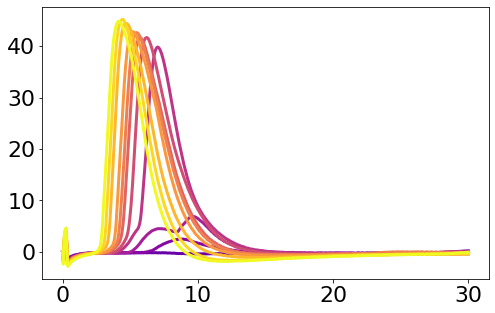

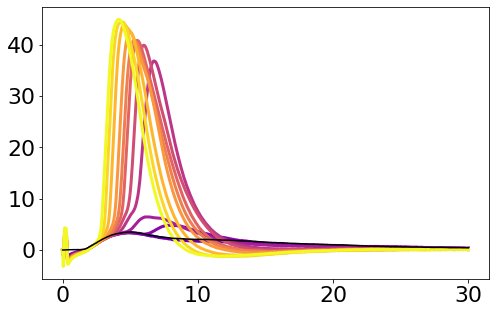

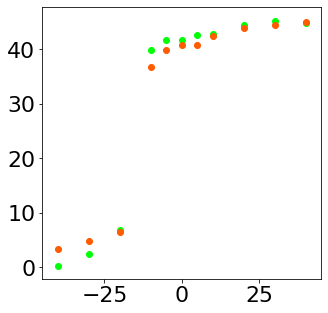

In [20]:
exptname = '20200719_001'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


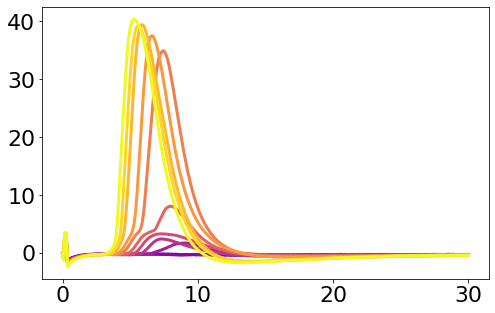

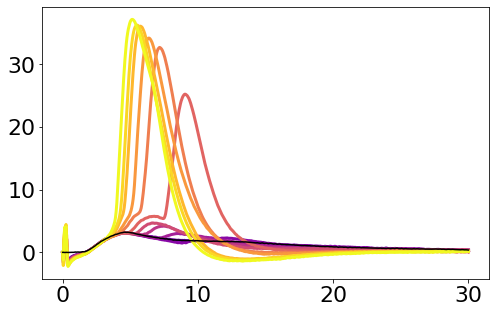

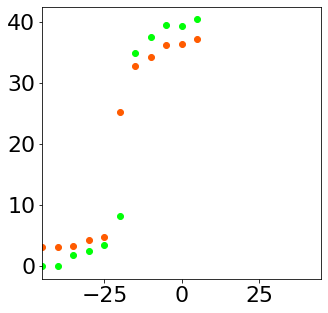

In [28]:
#reduced stim amp range
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


In [5]:
exptname = '20200719_004'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_004.smr


/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_004.smr


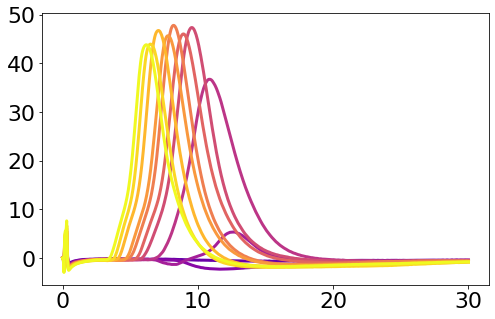

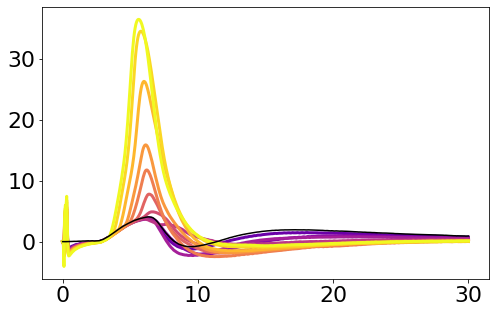

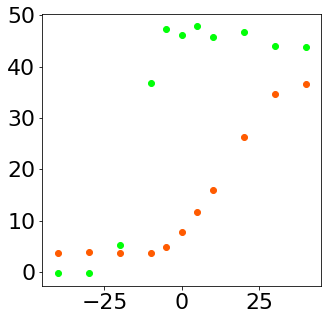

In [6]:
bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

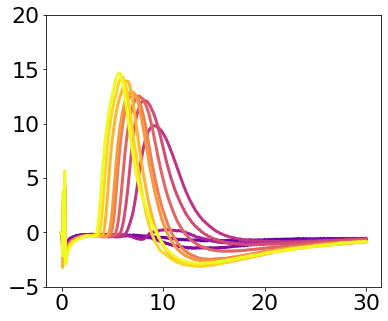

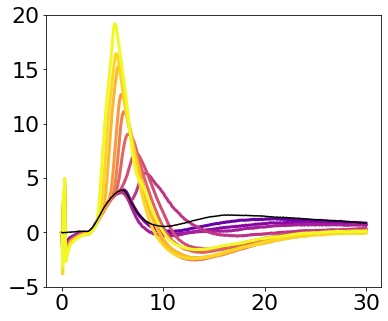

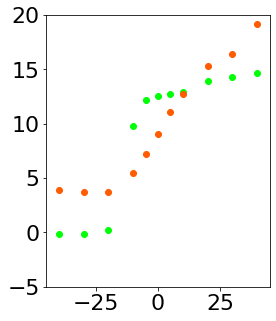

In [11]:
#hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[3]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


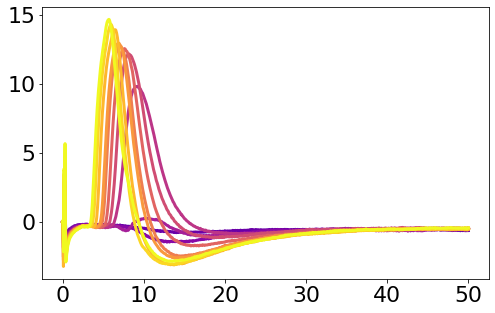

In [11]:
#smaller range stim amp to try to get threshold response 
bout_uc = [expt.get_bout_win('R','Keyboard')[3]]
sweepdur = 0.05

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
# ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
for i,sweep in enumerate(trialmat.T):
    plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
#     plt.ylim(-10,50)


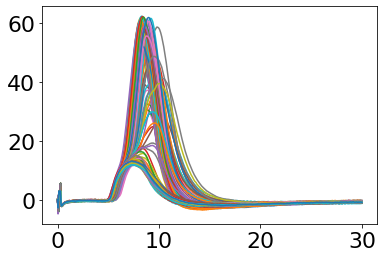

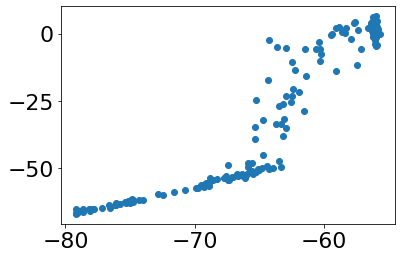

In [19]:
#changing bias current while do uncoupled stim... change ES response amp or is it a spike?
bout_uc = [expt.get_bout_win('U','Keyboard')[0]]
sweepdur = 0.03

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['U'])

xtime, sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
baseVm = np.asarray([sweep[0] for sweep in sweeps.T])
peakVm = np.asarray([np.max(sweep[int(0.002/expt.get_dt('lowgain')):]) for sweep in sweeps.T])
      
sweeps = np.asarray([sweep-sweep[0] for sweep in sweeps.T]).T
plt.plot(xtime,sweeps);

plt.figure()
plt.scatter(baseVm,peakVm)

/Users/kperks/mnt/engram/spikedata/data_raw/20200606/20200606_005.smr


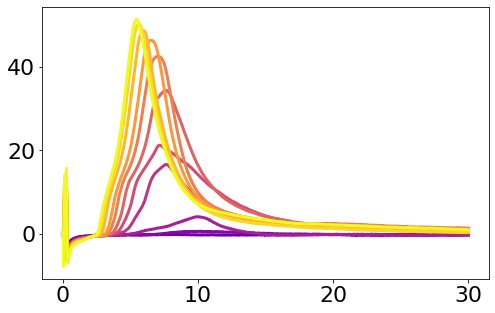

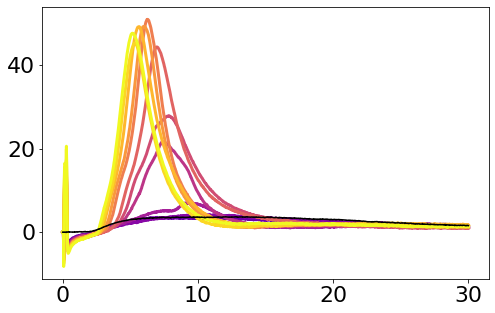

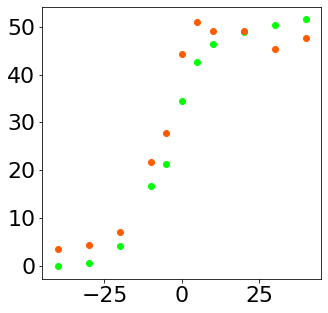

In [25]:
exptname = '20200606_005'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


In [3]:
expt = AmpShift_Stable()
expt.load_expt('20200607_005', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_005.smr


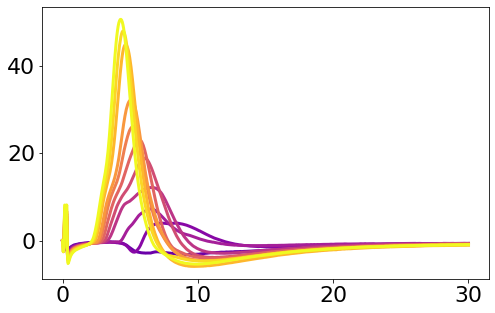

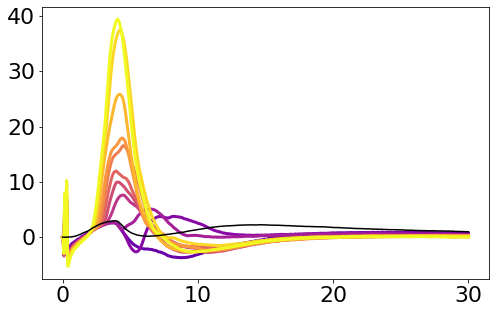

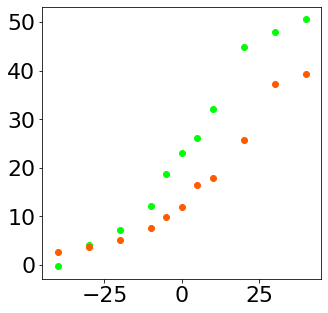

In [8]:


bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


(0, 10)

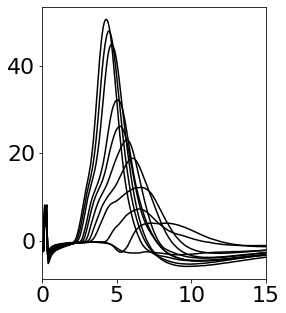

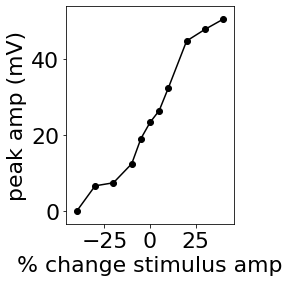

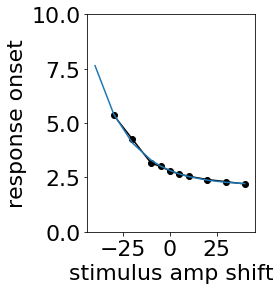

In [51]:
sweepdur = 0.03
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

trialmat = []
for a in np.unique(trial_df['ampshift_round']):
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

dt = expt.get_dt('lowgain')

min_peakt = 0.002 #(s)
threshold_h = 0.5 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

sweepdur = 0.03
basedur = 0.004

fsl = []
onset = []
amp = []
plt.figure(figsize=(4,5))
for sweep in trialmat.T:
    plt.plot(xtime,sweep,color = 'black');
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])
plt.xlim(0,15)
onset = np.asarray(onset)
amp = np.asarray(amp)
fsl = np.asarray(fsl)


plt.figure(figsize=(3,4))
plt.plot(np.unique(trial_df['ampshift_round']),amp,color = 'black')
plt.scatter(np.unique(trial_df['ampshift_round']),amp,color = 'black')
# plt.ylim(0,10)
plt.xlabel('% change stimulus amp')
plt.ylabel('peak amp (mV)')

x_data = np.unique(trial_df['ampshift_round'])[~np.isnan(onset)]
y_data = onset[~np.isnan(onset)]

params, params_covariance = optimize.curve_fit(exp_fit, x_data, y_data, p0=[1,-0.05, 1],maxfev=1000)

y = exp_fit(np.unique(trial_df['ampshift_round']),params[0],params[1],params[2])

plt.figure(figsize=(3,4))
plt.plot(np.unique(trial_df['ampshift_round']),onset,color = 'black')
plt.scatter(np.unique(trial_df['ampshift_round']),onset,color = 'black')
plt.ylim(0,10)
plt.xlabel('stimulus amp shift')
plt.ylabel('response onset')

plt.plot(np.unique(trial_df['ampshift_round']),y)
plt.ylim(0,10)

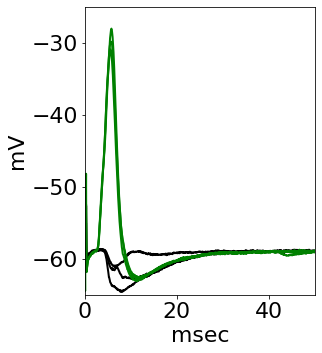

In [11]:
# bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
# trial_df = expt.filter_marker_df_code(bout_df,['T'])

hfig = plt.figure(figsize=(4,5))
ax1 = hfig.add_axes([0.1,0.1,0.8,0.8])
theseT = trial_df[trial_df['ampshift_round']==-40].time.values
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
ax1.plot(xtime,R[:,-3:],color = 'black',lw = 2,label='low stimulus amp')
theseT = trial_df[trial_df['ampshift_round']==0].time.values
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
ax1.plot(xtime,R[:,-3:],color = 'green',lw = 2,label='baseline stimulus amp')
ax1.set_xlim(0,50)
ax1.set_ylim(-65,-25)
ax1.set_xlabel('msec')
ax1.set_ylabel('mV')

h, l = ax1.get_legend_handles_labels()
# plt.legend(h[0],l[0],bbox_to_anchor=[1,1])

In [5]:
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

hfig = plt.figure(figsize=(4,5))
ax1 = hfig.add_axes([0.1,0.1,0.8,0.8])
theseT = trial_df[trial_df['ampshift_round']==-40].time.values
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
ax1.plot(xtime,R[:,-3:],color = 'black',lw = 2,label='low stimulus amp')
theseT = trial_df[trial_df['ampshift_round']==0].time.values
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
ax1.plot(xtime,R[:,-3:],color = 'green',lw = 2,label='baseline stimulus amp')
ax1.set_xlim(0,50)
ax1.set_ylim(-65,-25)
ax1.set_xlabel('msec')
ax1.set_ylabel('mV')

h, l = ax1.get_legend_handles_labels()
# plt.legend(h[0],l[0],bbox_to_anchor=[1,1])

NameError: name 'marker_df' is not defined

Text(0, 0.5, 'mV')

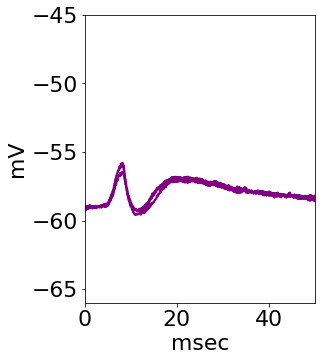

In [49]:

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['B'])

hfig = plt.figure(figsize=(4,5))
ax1 = hfig.add_axes([0.1,0.1,0.8,0.8])
theseT = trial_df.time.values
xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur = 0.05)
ax1.plot(xtime,R[:,-3:],color = 'purple',lw = 2)

ax1.set_xlim(0,50)
ax1.set_ylim(-66,-45)
ax1.set_xlabel('msec')
ax1.set_ylabel('mV')



Text(0.5, 0, 'msec')

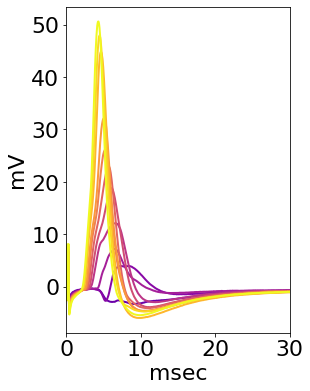

In [55]:
plt.figure(figsize=(4,6))
colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))

for i,sweep in enumerate(trialmat.T):
    plt.plot(xtime,sweep,color = colinds[i],lw = 2);
plt.xlim(0,30)
plt.ylabel('mV')
plt.xlabel('msec')



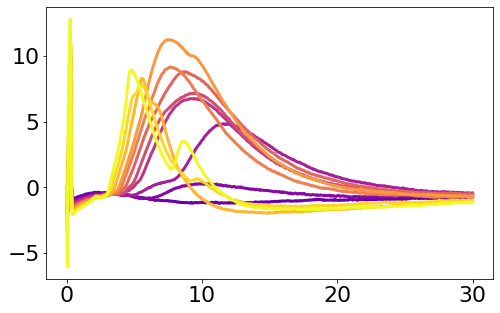

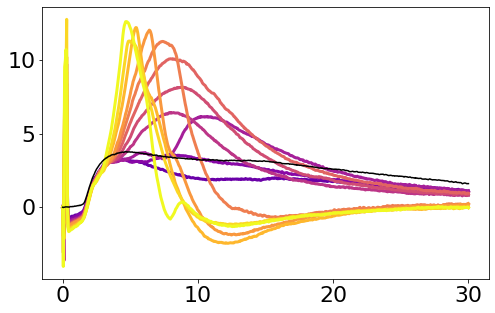

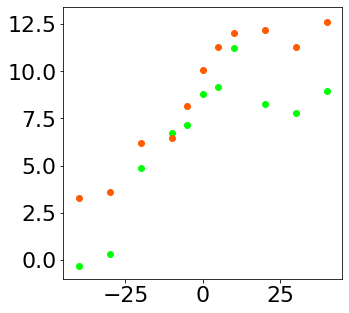

In [17]:
# expt = AmpShift_Stable()
# expt.load_expt('20200607_004', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


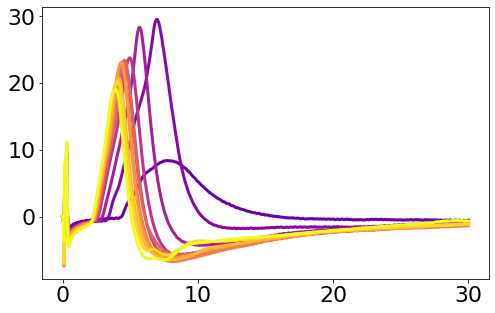

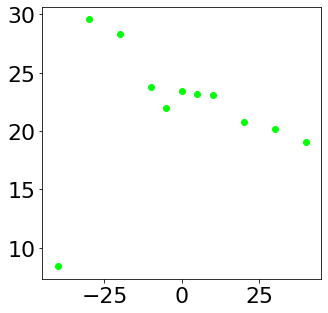

In [23]:
# expt = AmpShift_Stable()
# expt.load_expt('20200607_001', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
amp,Ramp_uc = uncoupled_ampshift(expt,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_002.smr


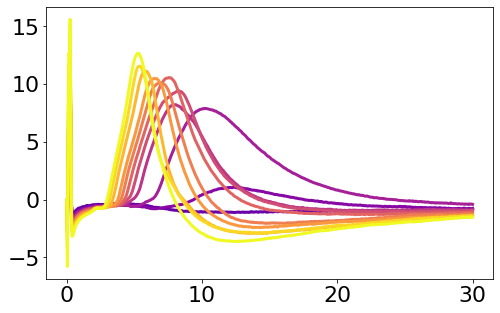

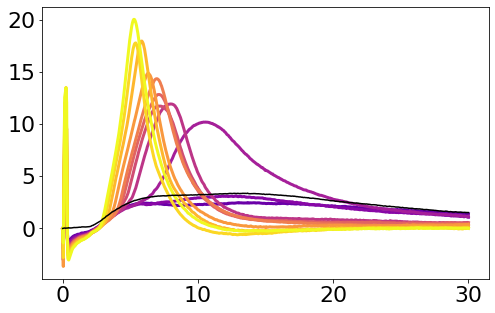

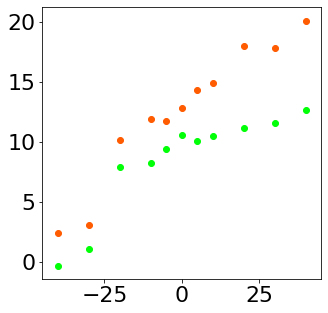

In [24]:
expt = AmpShift_Stable()
expt.load_expt('20200607_002', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
# amp,Ramp_uc = uncoupled_ampshift(expt,bout_uc,sweepdur = 0.03)

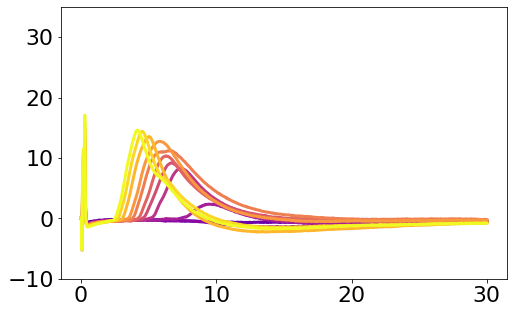

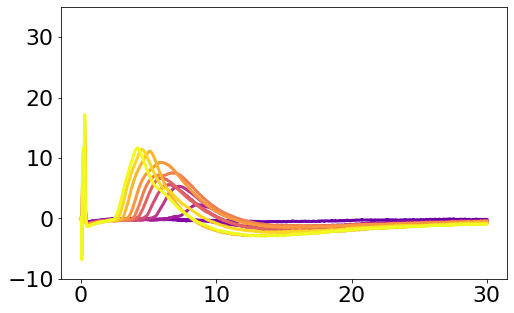

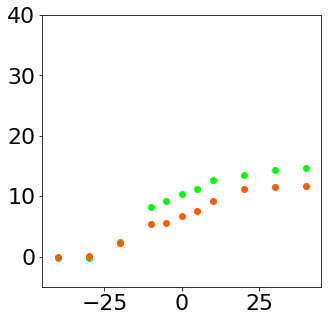

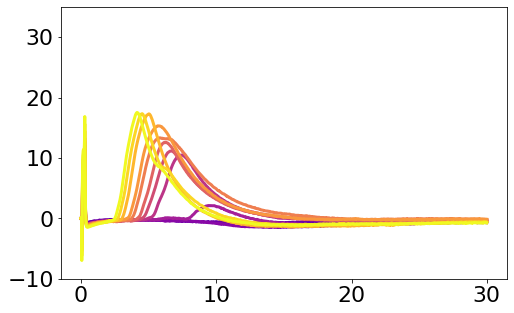

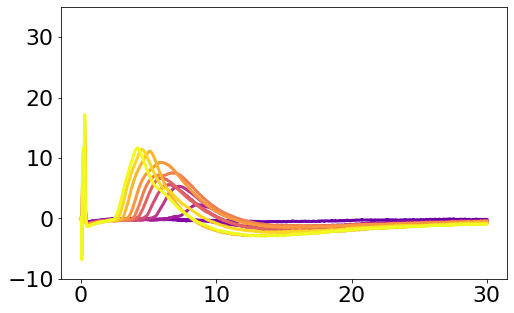

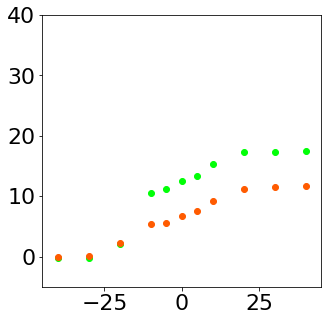

In [7]:
# expt = AmpShift_Stable()
# expt.load_expt('20200525_001', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# get onset of grc response across stim amp and fit exponential like do for afferent fsl

In [63]:
from scipy import optimize
def exp_fit(x, a, k, b):
    return a*np.exp(x*k) + b

(0, 10)

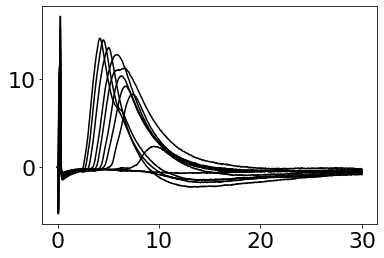

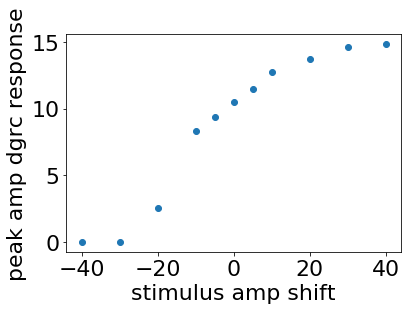

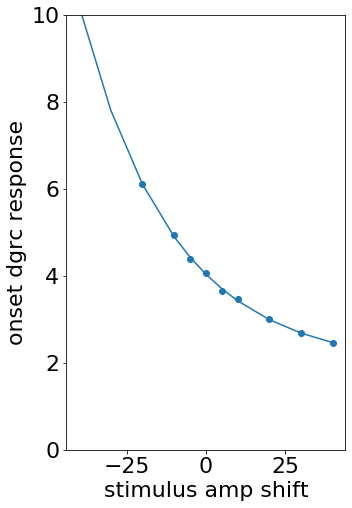

In [73]:
# expt = AmpShift_Stable()
# expt.load_expt('20200525_001', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
CmdTrig = expt.get_events('CmdTrig')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

trialmat = []
for a in np.unique(trial_df['ampshift_round']):
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

dt = expt.get_dt('lowgain')

min_peakt = 0.002 #(s)
threshold_h = 0.5 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

sweepdur = 0.03
basedur = 0.004

fsl = []
onset = []
amp = []
plt.figure()
for sweep in trialmat.T:
    plt.plot(xtime,sweep,color = 'black');
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])
    
onset = np.asarray(onset)
amp = np.asarray(amp)
fsl = np.asarray(fsl)


plt.figure()
plt.scatter(np.unique(trial_df['ampshift_round']),amp)
# plt.ylim(0,10)
plt.xlabel('stimulus amp shift')
plt.ylabel('peak amp dgrc response')

x_data = np.unique(trial_df['ampshift_round'])[~np.isnan(onset)]
y_data = onset[~np.isnan(onset)]

params, params_covariance = optimize.curve_fit(exp_fit, x_data, y_data, p0=[1,-0.05, 1],maxfev=1000)

y = exp_fit(np.unique(trial_df['ampshift_round']),params[0],params[1],params[2])

plt.figure(figsize=(5,8))

plt.scatter(np.unique(trial_df['ampshift_round']),onset)
plt.ylim(0,10)
plt.xlabel('stimulus amp shift')
plt.ylabel('onset dgrc response')

plt.plot(np.unique(trial_df['ampshift_round']),y)
plt.ylim(0,10)

/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_006.smr


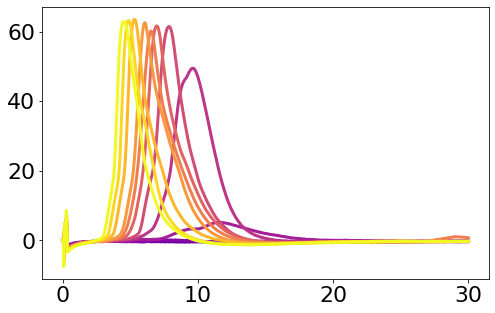

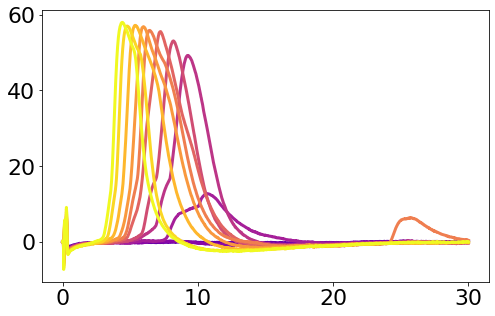

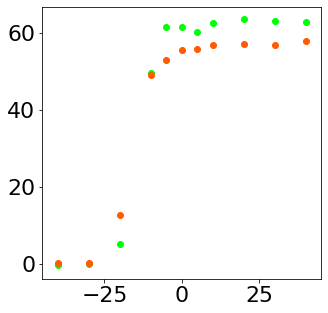

In [11]:
expt = AmpShift_Stable()
expt.load_expt('20200525_006', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200312/20200312_002.smr


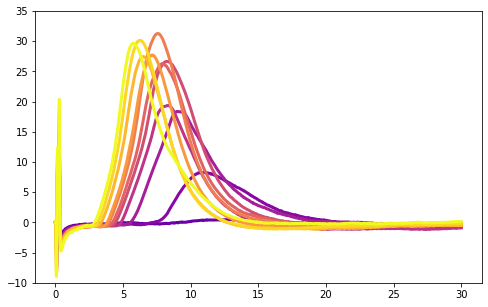

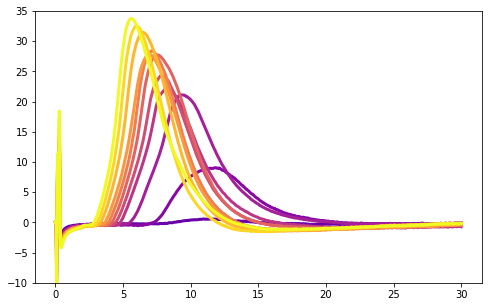

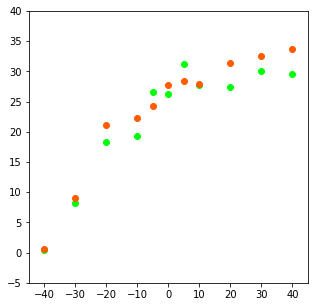

In [6]:
expt = AmpShift_Stable()
expt.load_expt('20200312_002', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200227/20200227_000.smr


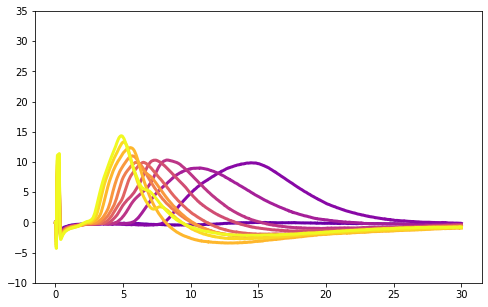

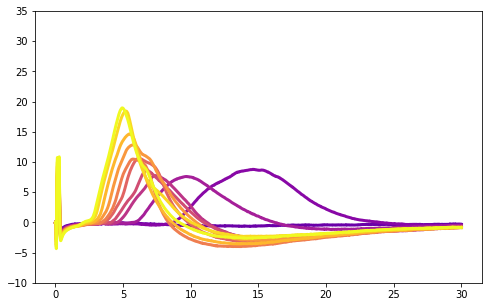

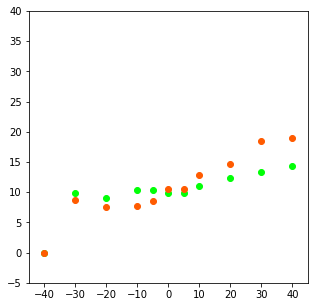

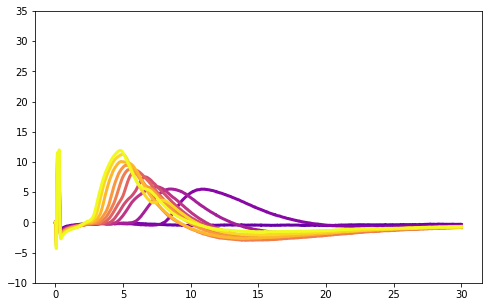

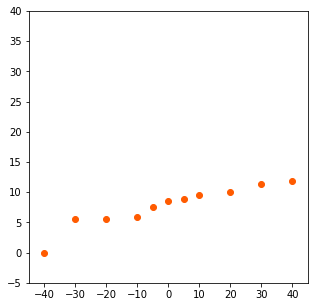

In [25]:
expt = AmpShift_Stable()
expt.load_expt('20200227_000', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# --> hyperpol but coupled only
# expt = AmpShift_Stable()
# expt.load_expt('20200312_000', data_folder)

# expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
# expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_c = [expt.get_bout_win('N','Keyboard')[2]]

amp,Ramp_c = coupled_ampshift(expt,bout_c,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200226/20200226_002.smr


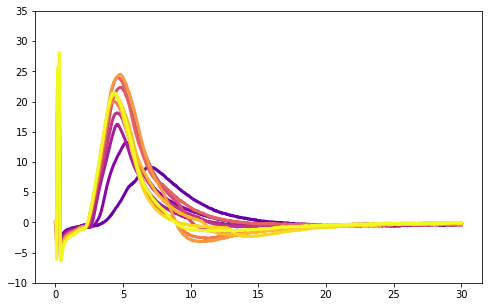

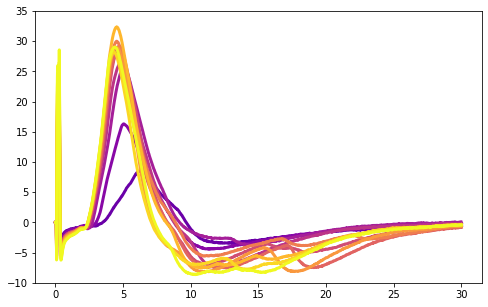

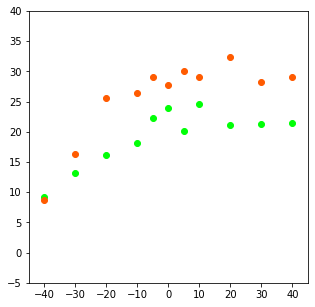

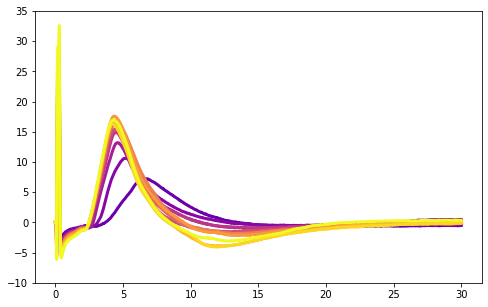

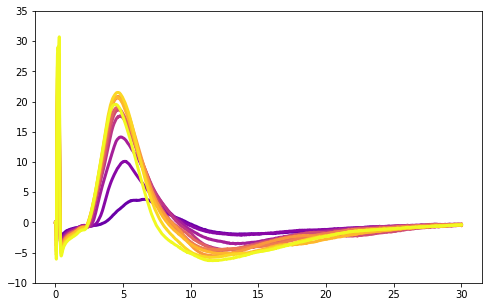

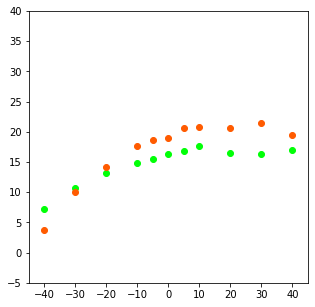

In [8]:
#at rest
expt = AmpShift_Stable()
expt.load_expt('20200226_002', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

#hyperpolarized
# expt = AmpShift_Stable()
# expt.load_expt('20200226_002', data_folder)

# expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
# expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

#(then there was another "at rest" bout to finish... so check this too)

/Users/kperks/mnt/engram/spikedata/data_raw/20200225/20200225_000.smr


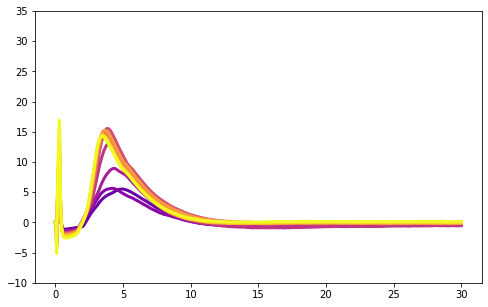

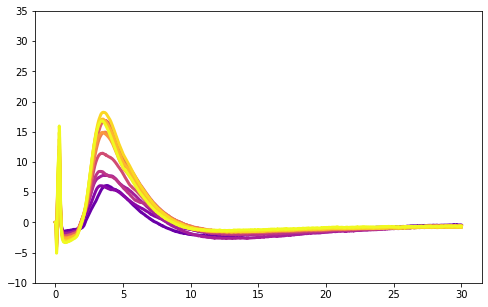

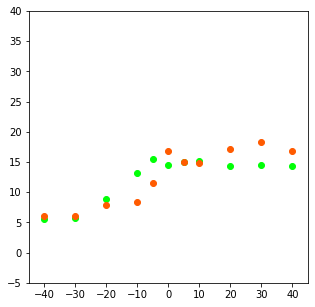

In [9]:
expt = AmpShift_Stable()
expt.load_expt('20200225_000', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200115/20200115_002.smr


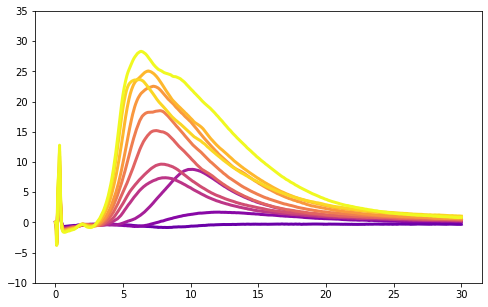

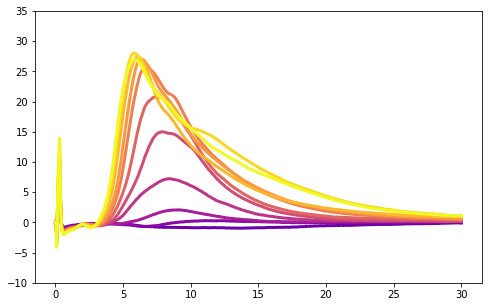

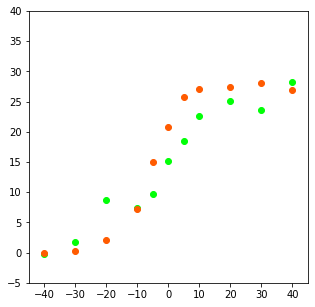

In [10]:
expt = AmpShift_Stable()
expt.load_expt('20200115_002', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200113/20200113_003.smr


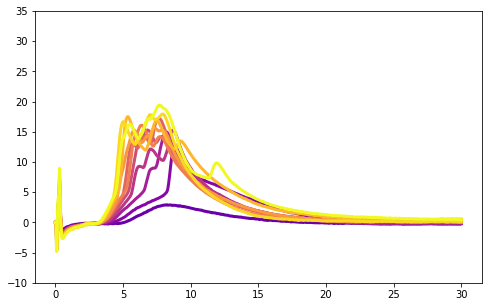

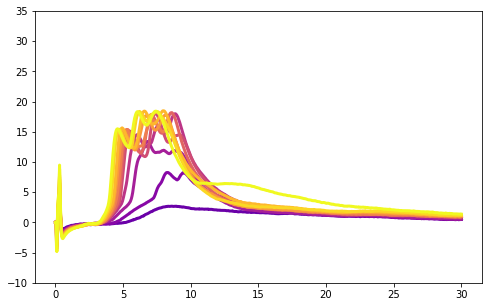

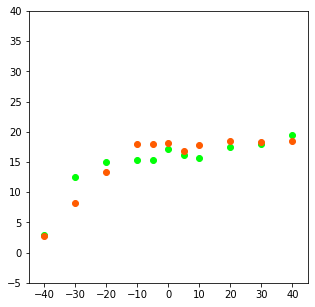

In [11]:
expt = AmpShift_Stable()
expt.load_expt('20200113_003', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200113/20200113_004.smr


(-10, 30)

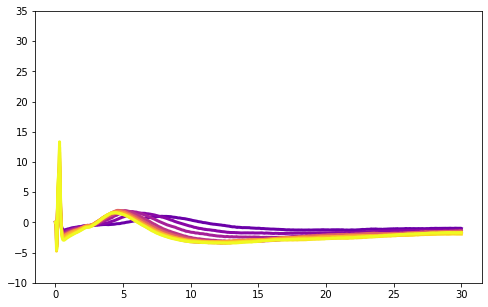

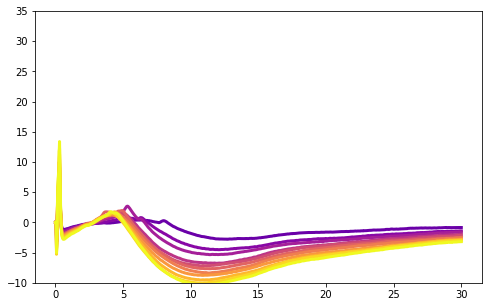

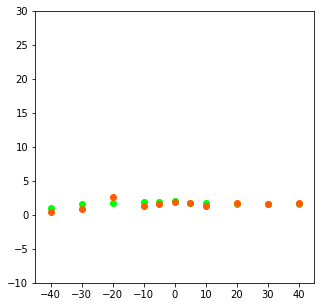

In [12]:
expt = AmpShift_Stable()
expt.load_expt('20200113_004', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0],expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
plt.ylim(-10,30)

/Users/kperks/mnt/engram/spikedata/data_raw/20200113/20200113_000.smr


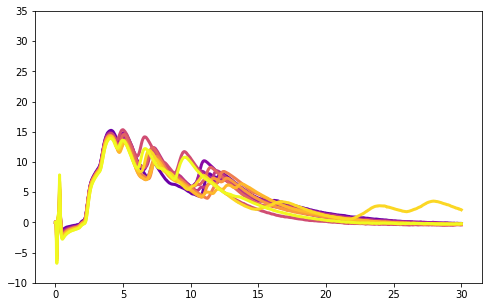

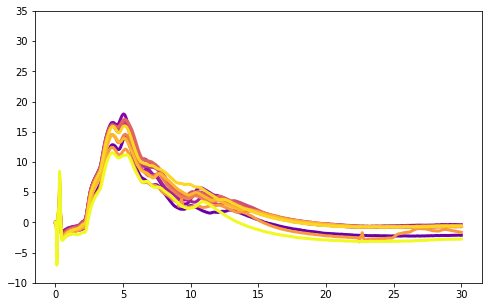

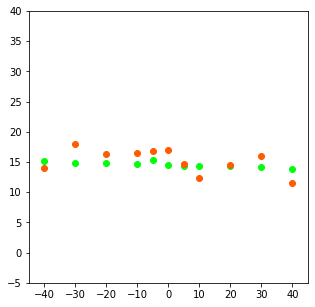

In [13]:
# ********DLZ********
expt = AmpShift_Stable()
expt.load_expt('20200113_000', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20191218/20191218_005.smr


(-40, 40)

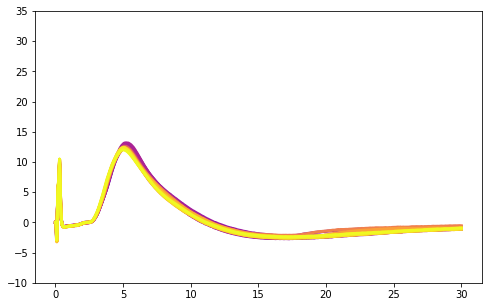

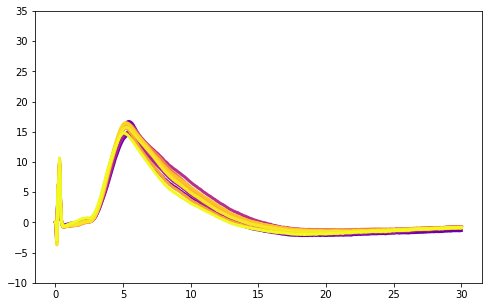

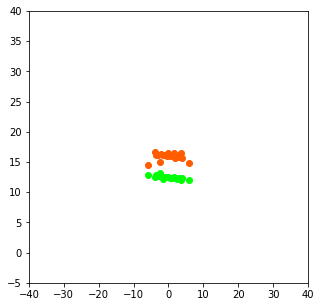

In [14]:
# ********smaller amplitude range********
expt = AmpShift_Stable()
expt.load_expt('20191218_005', data_folder)

expt.set_amps(19,[-6,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,6])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0],expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
plt.xlim(-40,40)

/Users/kperks/mnt/engram/spikedata/data_raw/20191218/20191218_009.smr


(-40, 40)

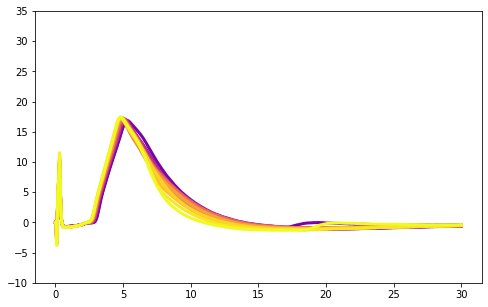

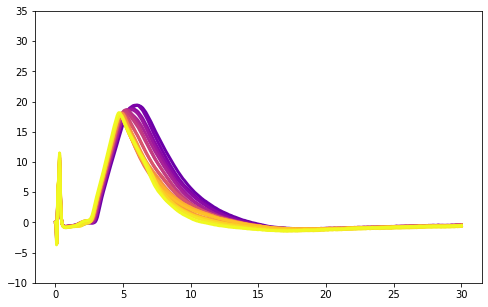

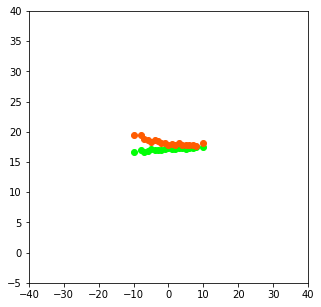

In [15]:
# ********mid amplitude range********
expt = AmpShift_Stable()
expt.load_expt('20191218_009', data_folder)

expt.set_amps(19,[-10,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,10])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0],expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)
plt.xlim(-40,40)

/Users/kperks/mnt/engram/spikedata/data_raw/20200122/20200122_001.smr


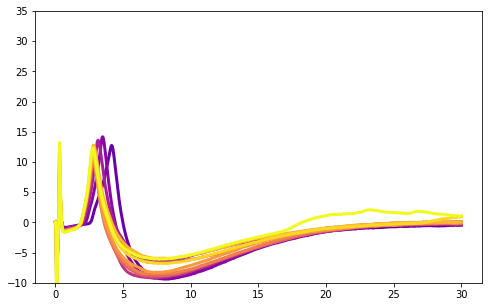

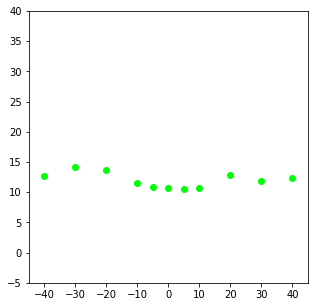

In [16]:
expt = AmpShift_Stable()
expt.load_expt('20200122_001', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]

amp,Ramp_uc = uncoupled_ampshift(expt,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200115/20200115_004.smr


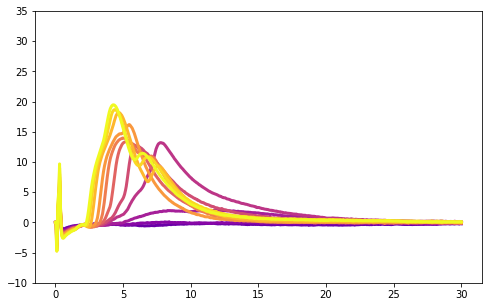

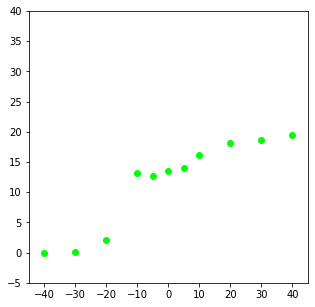

In [17]:
expt = AmpShift_Stable()
expt.load_expt('20200115_004', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]

amp,Ramp_uc = uncoupled_ampshift(expt,bout_uc,sweepdur = 0.03)

/Users/kperks/mnt/engram/spikedata/data_raw/20200312/20200312_000.smr


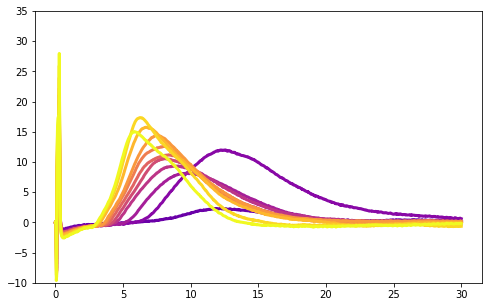

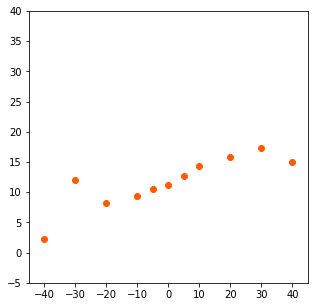

In [28]:
expt = AmpShift_Stable()
expt.load_expt('20200312_000', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_c = coupled_ampshift(expt,bout_c,sweepdur = 0.03)

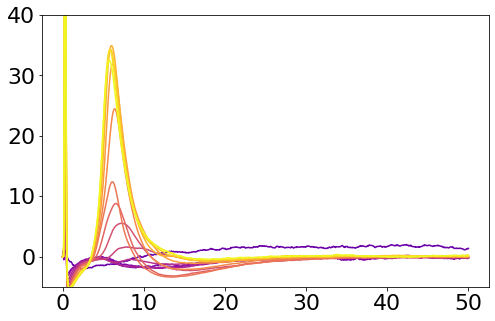

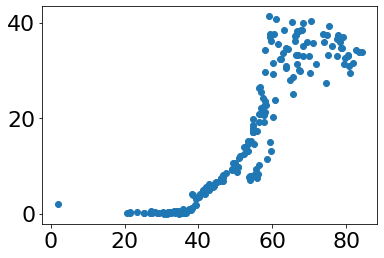

In [27]:
#shifted amplitude manually
exptname = '20171107_002'

# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

########
bout_uc = [expt.get_bout_win('A','Keyboard')[0]]

dt = expt.get_dt('lowgain')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['E'])
u_t = trial_df.time - 0.0003

eventdur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('lowgain',u_t,eventdur)
event_amp = np.asarray([np.max(sweep)-np.min(sweep) for sweep in event_sweeps.T])

sweepdur = 0.05
xtime,sweeps = expt.get_sweepsmat('lowgain',u_t,sweepdur)
R_amp = np.asarray([np.max(sweep[int(0.002/dt):]- sweep[0]) for sweep in sweeps.T])

bins = np.arange(np.floor(np.min(event_amp)),np.ceil(np.max(event_amp)),5)
ind = np.digitize(event_amp,bins)

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,len(np.unique(ind))))
for c,i in enumerate(np.unique(ind)):
    Ravg = np.mean(sweeps[:,(ind==i)],1)
    plt.plot(xtime,Ravg-Ravg[0],color = colinds[c])
plt.ylim(-5,40)
    
plt.figure()
plt.scatter(event_amp,R_amp)

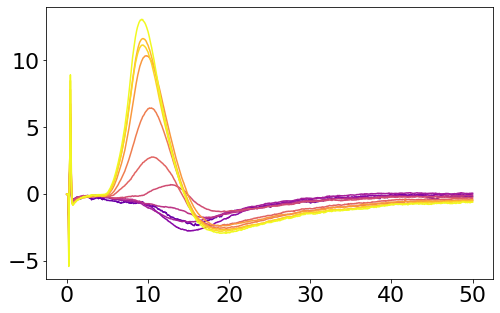

In [35]:
#shifted amplitude manually
exptname = '20170608_000'

# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

########
dt = expt.get_dt('lowgain')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

bout_c = [expt.get_bout_win('C','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['E'])
c_t = trial_df.time - 0.0003
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

bout_cmd = [expt.get_bout_win('B','Keyboard')[0],
            expt.get_bout_win('B','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout_cmd)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = trial_df.time

xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t+c_latency,sweepdur)
cmd_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

eventdur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('lowgain',c_t,eventdur)
event_amp = np.asarray([np.max(sweep)-np.min(sweep) for sweep in event_sweeps.T])

sweepdur = 0.05
xtime,sweeps = expt.get_sweepsmat('lowgain',c_t,sweepdur)
sweeps = np.asarray([sweep-cmd_ for sweep in sweeps.T]).T
R_amp = np.asarray([np.max(sweep[int(0.002/dt):]- sweep[0]) for sweep in sweeps.T])

#use bins and ind from uncoupled so can compare
bins = np.arange(np.floor(np.min(event_amp)),np.ceil(np.max(event_amp)),1)
ind = np.digitize(event_amp,bins)

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,len(np.unique(ind))))
for c,i in enumerate(np.unique(ind)):
    Ravg = np.mean(sweeps[:,(ind==i)],1)
    plt.plot(xtime,Ravg-Ravg[0],color = colinds[c])
    
event_amp_c = event_amp
R_amp_c = R_amp

Text(0.5, 1.0, 'cmd subtracted from coupled (orange)')

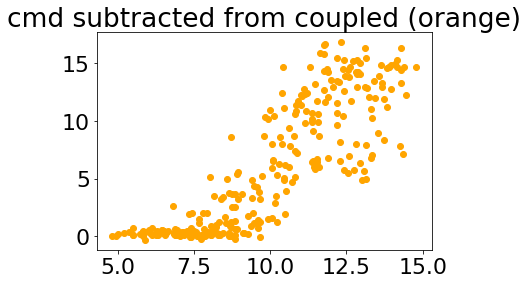

In [32]:
plt.figure()
plt.scatter(event_amp_c,R_amp_c,color = 'orange')
plt.title('cmd subtracted from coupled (orange)')

Text(0.5, 1.0, 'cmd subtracted ')

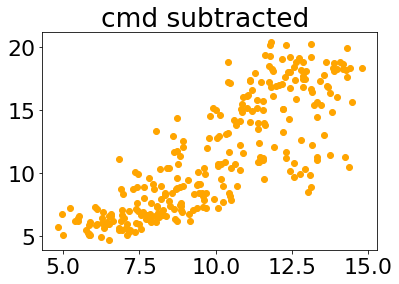

In [34]:
plt.figure()
plt.scatter(event_amp_c,R_amp_c,color = 'orange')
plt.title('cmd subtracted ')

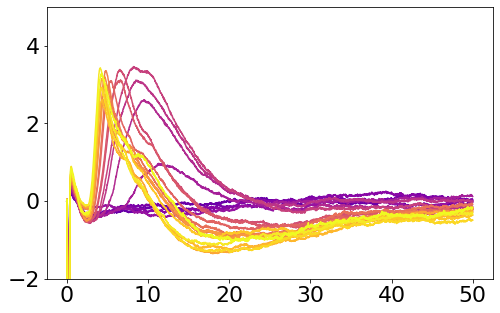

In [43]:
#shifted amplitude manually
exptname = '20190312_005'

# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

########
dt = expt.get_dt('lowgain')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

bout_c = [expt.get_bout_win('A','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['E'])
c_t = trial_df.time
b_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

bout_cmd = [expt.get_bout_win('B','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout_cmd)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cmd_t = trial_df.time

xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t+c_latency,sweepdur)
cmd_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

eventdur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',c_t,eventdur)
event_amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

sweepdur = 0.05
xtime,sweeps = expt.get_sweepsmat('lowgain',c_t,sweepdur)
sweeps = np.asarray([sweep-cmd_ for sweep in sweeps.T]).T
R_amp = np.asarray([np.max(sweep[int(0.002/dt):]- sweep[0]) for sweep in sweeps.T])

#use bins and ind from uncoupled so can compare
bins = np.arange(np.floor(np.min(event_amp)),np.ceil(np.max(event_amp)),20)
ind = np.digitize(event_amp,bins)

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,len(np.unique(ind))))
for c,i in enumerate(np.unique(ind)):
    Ravg = np.mean(sweeps[:,(ind==i)],1)
    plt.plot(xtime,Ravg-Ravg[0],color = colinds[c])
plt.ylim(-2,5)

event_amp_c = event_amp
R_amp_c = R_amp

Text(0.5, 1.0, 'cmd subtracted ')

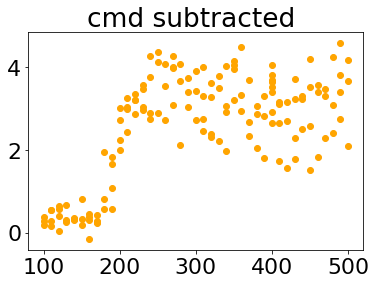

In [39]:
plt.figure()
plt.scatter(event_amp_c,R_amp_c,color = 'orange')
plt.title('cmd subtracted ')

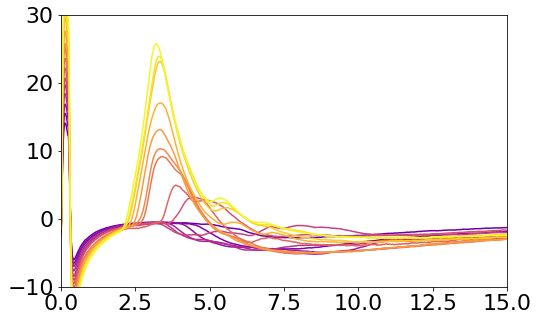

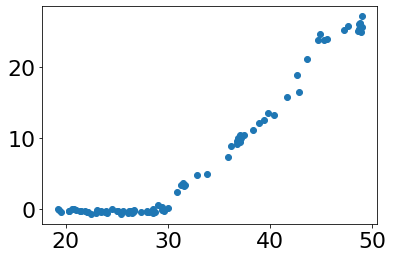

In [50]:
#shifted amplitude manually
exptname = '20190227_001'

# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

########
bout_uc = [expt.get_bout_win('U','Keyboard')[1]]

dt = expt.get_dt('lowgain')
marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['E'])
u_t = trial_df.time 

eventdur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('lowgain',u_t,eventdur)
event_amp = np.asarray([np.max(sweep)-np.min(sweep) for sweep in event_sweeps.T])

sweepdur = 0.05
xtime,sweeps = expt.get_sweepsmat('lowgain',u_t,sweepdur)
R_amp = np.asarray([np.max(sweep[int(0.002/dt):]- sweep[0]) for sweep in sweeps.T])

bins = np.arange(np.floor(np.min(event_amp)),np.ceil(np.max(event_amp)),2)
ind = np.digitize(event_amp,bins)

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,len(np.unique(ind))))
for c,i in enumerate(np.unique(ind)):
    Ravg = np.mean(sweeps[:,(ind==i)],1)
    plt.plot(xtime,Ravg-Ravg[0],color = colinds[c])
plt.ylim(-10,30)
plt.xlim(0,15)
    
plt.figure()
plt.scatter(event_amp,R_amp)

# TSD


/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_002.smr


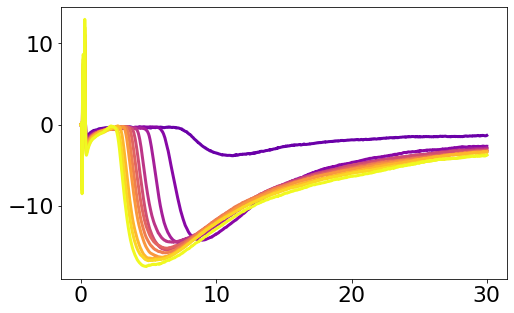

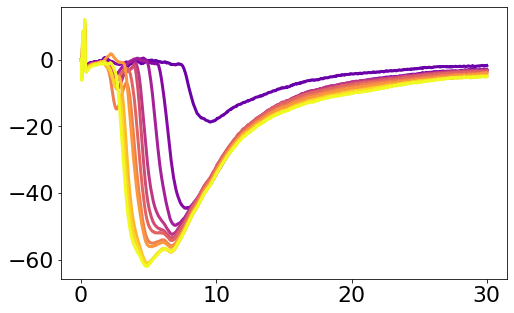

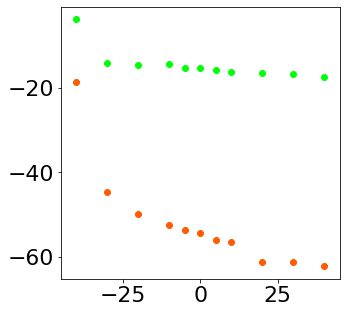

In [14]:
expt = AmpShift_Stable()
expt.load_expt('20200525_002', data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

# mystery cell

(-45, 45)

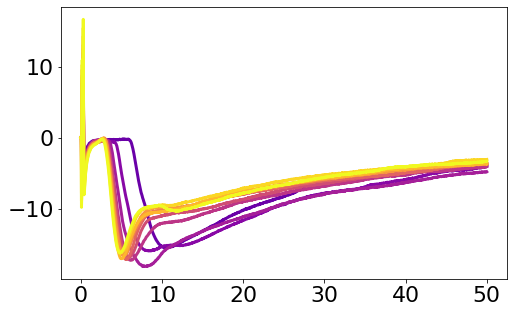

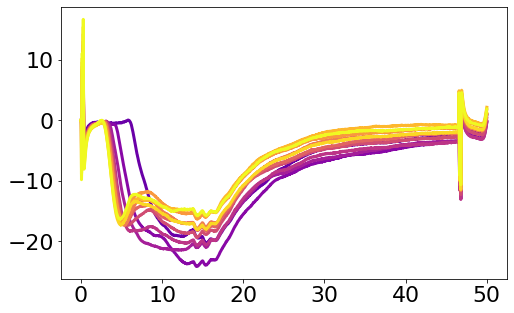

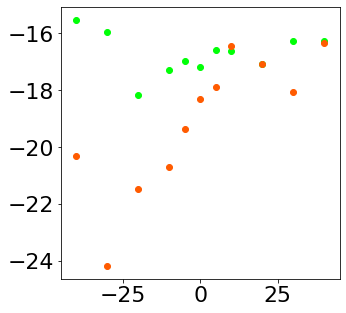

In [29]:
exptname = '20200524_003'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

CmdTrig = expt.get_events('CmdTrig')

#uncoupled
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

trialmat = []
for a in np.unique(trial_df['ampshift_round']):
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
for i,sweep in enumerate(trialmat.T):
    plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
# plt.ylim(-10,50)

dt = expt.get_dt('lowgain')
Ramp_uc = np.asarray([np.min(sweep[int(0.002/dt):]) for sweep in trialmat.T])

#coupled
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

trialmat = []
for a in np.unique(trial_df['ampshift_round']):
    theseT = trial_df[trial_df['ampshift_round']==a].time.values
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

cmd_df = expt.filter_marker_df_code(bout_df,['C'])
cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
C_latency = np.median(cmd_df.time.values-cmd_t)

cmd_df = expt.filter_marker_df_code(bout_df,['U'])
cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
xtime,cmd_sweeps = expt.get_sweepsmat('lowgain',cmd_t+C_latency,sweepdur)
cmd_R = np.mean(cmd_sweeps,1)-np.mean(cmd_sweeps,1)[0]

trialmat = np.asarray([sweep-cmd_R for sweep in trialmat.T]).T

plt.figure(figsize=(8,5))
colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
for i,sweep in enumerate(trialmat.T):
    plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
# plt.ylim(-10,50)

dt = expt.get_dt('lowgain')
Ramp_c = np.asarray([np.min(sweep[int(0.002/dt):]) for sweep in trialmat.T])

plt.figure(figsize = (5,5))
plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
plt.scatter(np.unique(trial_df['ampshift_round']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
# plt.ylim(-5,50)
plt.xlim(-45,45)

# without cmd subtracted there is no difference between coupled and uncoupled... so what would be the point of the cmd alone???

Text(0.5, 1.0, 'at rest')

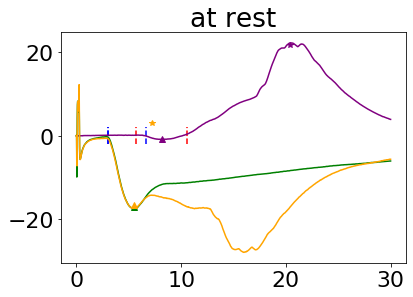

In [27]:
sweepdur = 0.03

fig = plt.figure(num=1)
ax = fig.add_axes([0.1,0.1,0.8,0.8])

bout = [expt.get_bout_win('B','Keyboard')[0],
       expt.get_bout_win('U','Keyboard')[0],
       expt.get_bout_win('C','Keyboard')[1]]

marker_df = expt.get_marker_table()
dt = expt.get_dt('lowgain')
bout_df = expt.filter_marker_df_time(marker_df,bout)

b_df = expt.filter_marker_df_code(bout_df,['B'])
u_df = expt.filter_marker_df_code(bout_df,['U'])
c_df = expt.filter_marker_df_code(bout_df,['C'])

u_t = u_df.time.values
c_t = c_df.time.values
#from uncoupled trials get times for command responses
cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in u_t])

#calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t])
c_latency = np.median(c_t-cmd_coupled_t)

cell_data = get_results(expt,cmd_t,u_t,c_t,c_latency,1,ax)
ax.set_title('at rest')

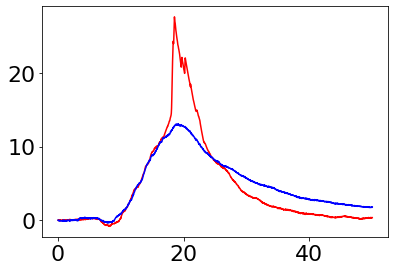

In [28]:
sweepdur = 0.05
marker_df = expt.get_marker_table() 
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
##cmd
bout = [expt.get_bout_win('B','Keyboard')[0]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime, sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
ax.plot(xtime,np.median(sweeps,1)-np.median(sweeps,1)[0],color = 'red');

bout = [expt.get_bout_win('B','Keyboard')[1]]
bout_df = expt.filter_marker_df_time(marker_df,bout)
trial_df = expt.filter_marker_df_code(bout_df,['B'])
xtime, sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
ax.plot(xtime,np.median(sweeps,1)-np.median(sweeps,1)[0],color = 'blue');
